## Languages and Scripts



### What languages are most common?

In [14]:
import pandas as pd
import altair as alt

from utils import pgp_csv_paths, chart_dir

documents = pd.read_csv(pgp_csv_paths["documents"])

In [15]:
# combine primary and secondary languages into an all-lang field


def all_langs(row):
  # apparently we can't assume that secondary lang implies primary!
    if pd.notna(row.languages_primary):
      if pd.notna(row.languages_secondary):
        return ','.join([row.languages_primary, row.languages_secondary])
      else:
        return row.languages_primary

    # at least one case has a secondary lang without primary; return it
    if pd.notna(row.languages_secondary):
      return row.languages_secondary

documents['languages_all'] = documents.apply(all_langs, axis=1)
documents[['pgpid', 'languages_primary', 'languages_secondary', 'languages_all']].head()

,pgpid,languages_primary,languages_secondary,languages_all
0,444,Judaeo-Arabic,NaN,Judaeo-Arabic
1,445,Hebrew,NaN,Hebrew
2,446,"Aramaic, Hebrew",NaN,"Aramaic, Hebrew"
3,447,Judaeo-Arabic,NaN,Judaeo-Arabic
4,448,Judaeo-Arabic,NaN,Judaeo-Arabic


In [16]:
# as we did with tags, split and explode the combined languages into list
documents['langs_all_list'] = documents.languages_all.apply(lambda x: (x.strip().split(",")) if pd.notna(x) else [])

docs_langs = documents[['pgpid', 'langs_all_list']].explode('langs_all_list').rename(columns={"langs_all_list": "language"})
# filter out unset languages
docs_langs = docs_langs[docs_langs.language.notna()]
# ensure whitespace doesn't cause variation
docs_langs['language'] = docs_langs.language.apply(lambda x : x.strip())

docs_langs.head(10)

,pgpid,language
0,444,Judaeo-Arabic
1,445,Hebrew
2,446,Aramaic
2,446,Hebrew
3,447,Judaeo-Arabic
4,448,Judaeo-Arabic
5,449,Judaeo-Arabic
6,451,Judaeo-Arabic
12,458,Judaeo-Arabic
13,459,Judaeo-Arabic


In [17]:
# total by language, for any occurrence (counting documents multiply)
doc_lang_counts = docs_langs.language.value_counts().reset_index()
doc_lang_counts.head(10)

,language,count
0,Judaeo-Arabic,15885
1,Arabic,9539
2,Hebrew,7644
3,Aramaic,1756
4,Greek/Coptic Numerals,879
5,Ladino,368
6,Judaeo-Persian,102
7,French,49
8,Unidentified language and script,40
9,Spanish,39


How many unique languages total?

In [18]:
total_langs = len(doc_lang_counts.language.unique())
total_langs

54

In [19]:
# create a filter set of most common and unidentified

doc_lang_counts_subset = doc_lang_counts[(doc_lang_counts['count'] > 300) | doc_lang_counts.language.str.contains("Unidentified")]
# format count for output
doc_lang_counts_subset['count'] = doc_lang_counts_subset['count'].apply(lambda x: f"{x:,}")
# rename columns for output
doc_lang_counts_subset = doc_lang_counts_subset.rename(columns={"language": "Language/Script","count": "Documents"})
doc_lang_counts_subset

/var/folders/mb/6qm4h4yx3yqdy2bv2sjyp4z00000gp/T/ipykernel_24839/2189796858.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doc_lang_counts_subset['count'] = doc_lang_counts_subset['count'].apply(lambda x: f"{x:,}")


,Language/Script,Documents
0,Judaeo-Arabic,"15,885"
1,Arabic,"9,539"
2,Hebrew,"7,644"
3,Aramaic,"1,756"
4,Greek/Coptic Numerals,879
5,Ladino,368
8,Unidentified language and script,40
14,Unidentified (Hebrew script),22
24,Unidentified (Latin script),8


In [20]:
print(doc_lang_counts_subset.to_latex(index=False))

\begin{tabular}{ll}
\toprule
Language/Script & Documents \\
\midrule
Judaeo-Arabic & 15,885 \\
Arabic & 9,539 \\
Hebrew & 7,644 \\
Aramaic & 1,756 \\
Greek/Coptic Numerals & 879 \\
Ladino & 368 \\
Unidentified language and script & 40 \\
Unidentified (Hebrew script) & 22 \\
Unidentified (Latin script) & 8 \\
\bottomrule
\end{tabular}



### What % of documents have more than one language?

(any language - primary or secondary)

In [21]:
# tally the number of languages using the combined list field we created before
documents['langs_all_count'] = documents.langs_all_list.apply(lambda x: len(x))

### Language combinations

### upSet plot

In [22]:
# limit to languages that occur a sufficient number of times
min_langcount = 300

lang_subset = doc_lang_counts[doc_lang_counts["count"] > min_langcount].language.to_list()
lang_subset

['Judaeo-Arabic',
 'Arabic',
 'Hebrew',
 'Aramaic',
 'Greek/Coptic Numerals',
 'Ladino']

In [23]:
from upsetplot import from_memberships


# limit to documents with any of the languages in our subset
# create a filtered lang field with languages in our subset
documents['subset_langs'] = documents.langs_all_list.apply(lambda x: [l.strip() for l in x if l.strip() in lang_subset]) #list(set(l.strip() for l in x) & set(lang_subset)))

documents_subset_lang = documents[documents.subset_langs.notna() & documents.subset_langs.str.len()].copy()
documents_subset_lang[documents_subset_lang.langs_all_count > 1 ][documents_subset_lang.languages_all.str.contains("Judaeo-Arabic")][['pgpid', 'languages_all', 'langs_all_list', 'subset_langs']]

/var/folders/mb/6qm4h4yx3yqdy2bv2sjyp4z00000gp/T/ipykernel_24839/1994218633.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  documents_subset_lang[documents_subset_lang.langs_all_count > 1 ][documents_subset_lang.languages_all.str.contains("Judaeo-Arabic")][['pgpid', 'languages_all', 'langs_all_list', 'subset_langs']]


,pgpid,languages_all,langs_all_list,subset_langs
35,489,"Aramaic, Judaeo-Arabic,Hebrew","[Aramaic, Judaeo-Arabic, Hebrew]","[Aramaic, Judaeo-Arabic, Hebrew]"
92,563,"Aramaic, Hebrew, Judaeo-Arabic","[Aramaic, Hebrew, Judaeo-Arabic]","[Aramaic, Hebrew, Judaeo-Arabic]"
97,568,"Arabic, Hebrew, Judaeo-Arabic","[Arabic, Hebrew, Judaeo-Arabic]","[Arabic, Hebrew, Judaeo-Arabic]"
326,834,"Judaeo-Arabic,Arabic,Hebrew","[Judaeo-Arabic, Arabic, Hebrew]","[Judaeo-Arabic, Arabic, Hebrew]"
418,928,"Judaeo-Arabic,Aramaic,Hebrew","[Judaeo-Arabic, Aramaic, Hebrew]","[Judaeo-Arabic, Aramaic, Hebrew]"
...,...,...,...,...
34752,40329,"Arabic, Greek/Coptic Numerals, Judaeo-Arabic","[Arabic, Greek/Coptic Numerals, Judaeo-Arabic]","[Arabic, Greek/Coptic Numerals, Judaeo-Arabic]"
34829,40409,"Arabic, Hebrew, Judaeo-Arabic","[Arabic, Hebrew, Judaeo-Arabic]","[Arabic, Hebrew, Judaeo-Arabic]"
34862,40443,"Judaeo-Arabic,Hebrew,Ladino","[Judaeo-Arabic, Hebrew, Ladino]","[Judaeo-Arabic, Hebrew, Ladino]"
35144,40728,"Judaeo-Arabic,Aramaic,Hebrew","[Judaeo-Arabic, Aramaic, Hebrew]","[Judaeo-Arabic, Aramaic, Hebrew]"


In [24]:
pd.set_option('future.no_silent_downcasting', True)

# use the combined subset language field as the membership set
lang_memberships = documents_subset_lang.subset_langs
lang_sets = from_memberships(lang_memberships)

/Users/rkoeser/workarea/github/pgp-dataset-essay/.venv/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/rkoeser/workarea/github/pgp-dataset-essay/.venv/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the in

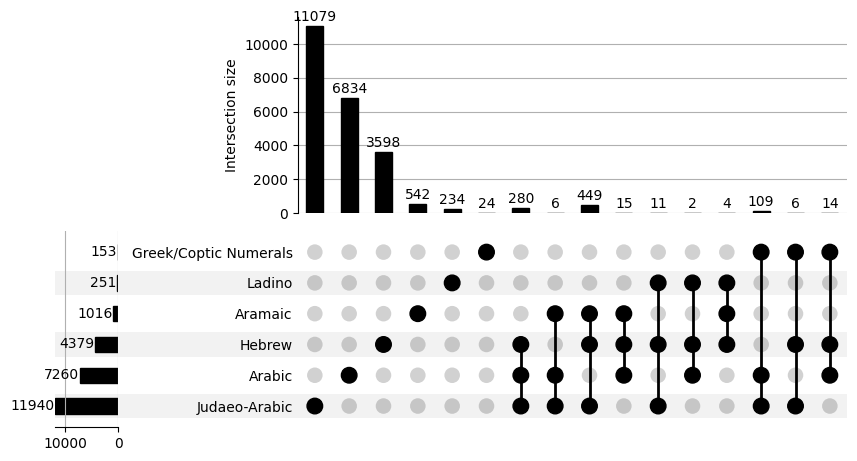

In [25]:
from upsetplot import plot
from matplotlib import pyplot

figure = pyplot.figure()

upset_plot = plot(lang_sets, fig=figure, subset_size="count", show_counts=True) # , sort_categories_by='-input')

# NOTE: must save _before_ displaying (show clears the current plot)
# pyplot.savefig(f'{chart_dir}/language_upsetplot.pdf')
pyplot.show(upset_plot)


#### upSet plot of primary languages

In [26]:
lang_subset

['Judaeo-Arabic',
 'Arabic',
 'Hebrew',
 'Aramaic',
 'Greek/Coptic Numerals',
 'Ladino']

In [27]:

# limit to documents with any of the languages in our subset
# create a filtered lang field with languages in our subset
documents['primary_lang_list'] = documents.languages_primary.apply(lambda x: [l.strip() for l in x.split(',')] if pd.notna(x) else [])

documents['subset_primary_langs'] = documents.primary_lang_list.apply(lambda x: [l.strip() for l in x if l.strip() in lang_subset]) #list(set(l.strip() for l in x) & set(lang_subset)))

documents_primary_subset_lang = documents[documents.subset_primary_langs.notna() & documents.subset_primary_langs.str.len()]
documents_primary_subset_lang[documents_primary_subset_lang.langs_all_count > 1 ][documents_primary_subset_lang.languages_all.str.contains("Ladino")][['pgpid', 'languages_primary', 'primary_lang_list', 'subset_primary_langs']].head(10)

/var/folders/mb/6qm4h4yx3yqdy2bv2sjyp4z00000gp/T/ipykernel_24839/695474924.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  documents_primary_subset_lang[documents_primary_subset_lang.langs_all_count > 1 ][documents_primary_subset_lang.languages_all.str.contains("Ladino")][['pgpid', 'languages_primary', 'primary_lang_list', 'subset_primary_langs']].head(10)


,pgpid,languages_primary,primary_lang_list,subset_primary_langs
8612,11187,Hebrew,[Hebrew],[Hebrew]
8730,11322,Ladino,[Ladino],[Ladino]
9736,12403,Ladino,[Ladino],[Ladino]
14005,16997,Ladino,[Ladino],[Ladino]
15854,19003,"Hebrew, Judaeo-Arabic, Ladino","[Hebrew, Judaeo-Arabic, Ladino]","[Hebrew, Judaeo-Arabic, Ladino]"
16262,19437,Judaeo-Arabic,[Judaeo-Arabic],[Judaeo-Arabic]
16413,19666,"Hebrew, Judaeo-Arabic, Ladino","[Hebrew, Judaeo-Arabic, Ladino]","[Hebrew, Judaeo-Arabic, Ladino]"
16445,19708,"Ladino, Spanish","[Ladino, Spanish]",[Ladino]
16446,19709,"Ladino, Unidentified language and script","[Ladino, Unidentified language and script]",[Ladino]
16559,19830,Ladino,[Ladino],[Ladino]


In [28]:
# use the combined subset language field as the membership set
primary_lang_memberships = documents_primary_subset_lang.subset_primary_langs
primary_lang_sets = from_memberships(primary_lang_memberships)

/Users/rkoeser/workarea/github/pgp-dataset-essay/.venv/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/rkoeser/workarea/github/pgp-dataset-essay/.venv/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the in

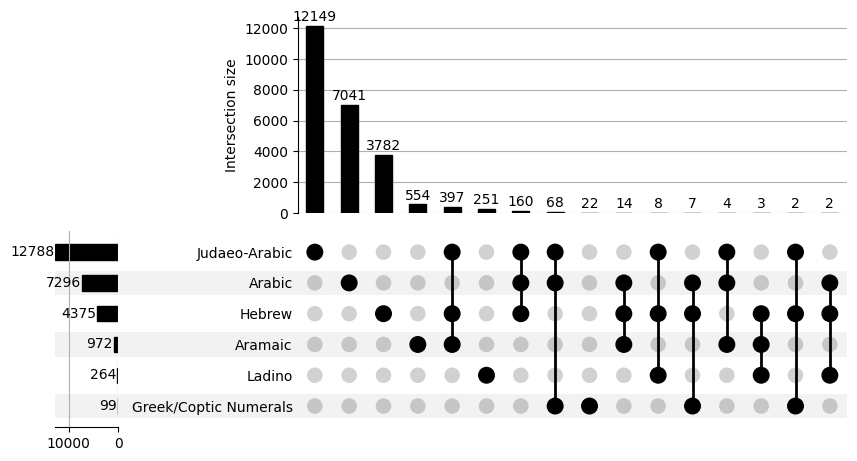

In [29]:
from upsetplot import UpSet


upset_plot_primary = UpSet(primary_lang_sets, subset_size="count", show_counts=True, sort_by='cardinality', sort_categories_by='-cardinality').plot()

pyplot.savefig(f'{chart_dir}/primary_language_upsetplot.pdf')

pyplot.savefig(f'{chart_dir}/language_upsetplot.pdf')
pyplot.show(upset_plot_primary)